In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("dataset/english_cleaned_lyrics.csv")
df.head()

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [ ]:
# %cd /content/drive/My\ Drive/DL_Project/classifier/SongGenreClassification/dataset
# !pwd
# !unzip english_cleaned_lyrics.zip


In [ ]:
import numpy as np
import pandas as pd
import string
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
import json
import sklearn
from sklearn import preprocessing as skpp
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# English-only pre-processed song lyrics
data = pd.read_csv("dataset/english_cleaned_lyrics.csv")
data.head()

def readData(file) :
  data = pd.read_csv(file)
  data.head()
  return data


In [ ]:
data_filter = data.loc[(data['genre'] == 'Country') | (data['genre'] == "Hip-Hop")] #filter to keep Country and Hip Hop Songs
display(data_filter.head())
print("Size of data", data_filter.shape)

print("Size of country data", (data_filter.loc[(data_filter['genre'] == 'Country')]).shape)

print("Size of hip hop data", (data_filter.loc[(data_filter['genre'] == 'Hip-Hop')]).shape)

,Unnamed: 0,index,song,year,artist,genre,lyrics
228,249,249,i-got-that,2007,eazy-e,Hip-Hop,horns chorus Timbo When you hit me on my phon...
229,250,250,8-ball-remix,2007,eazy-e,Hip-Hop,Verse 1 I don't drink brass monkey like to be ...
230,251,251,extra-special-thankz,2007,eazy-e,Hip-Hop,19 muthaphukkin 93 and I'm back in this bitch ...
231,252,252,boyz-in-da-hood,2007,eazy-e,Hip-Hop,Hey yo man remember that shit Eazy did a while...
232,253,253,automoblie,2007,eazy-e,Hip-Hop,Yo Dre man I take this bitch out to the movies...


Size of data (36812, 7)
Size of country data (14158, 7)
Size of hip hop data (22654, 7)


In [ ]:
lyric_data = data_filter['lyrics'].values
max_words = 30000
df_copy = data_filter
# Create a new Tokenizer
tokenizer = text.Tokenizer(num_words=max_words, oov_token='<UNK>')
# Feed song lyrics to the Tokenizer
tokenizer.fit_on_texts(lyric_data)
# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
    
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1
indexed_data = tokenizer.texts_to_sequences(lyric_data)
indexed_data = np.array(indexed_data)

label_encoder = skpp.LabelEncoder()
lbl_enc = label_encoder.fit_transform(data_filter['genre'].values)
indexed_labels = np.array(lbl_enc)
label_encoder.inverse_transform(indexed_labels) # To get original genre text back
label_types = (0, 1)
genre_df = pd.DataFrame(label_types, columns = ['Label'])
genre_df['Genre'] = label_encoder.inverse_transform(np.array([0,1]))
display(genre_df)
num_test = 30000

# Shuffle data before splitting off test set
random_indexes = np.random.permutation(len(indexed_labels))
indexed_data = indexed_data[random_indexes]
indexed_labels = indexed_labels[random_indexes]
#print(indexed_data.shape)
X_test = indexed_data[:-num_test]
y_test = indexed_labels[:-num_test]
X_train  = indexed_data[-num_test:]
y_train  = indexed_labels[-num_test:]
# print(X_test.shape)
# print(X_train.shape)

# display(df_copy)
# print(df_copy.shape)
# print(random_indexes)
# df_c = df_copy.iloc[random_indexes]
# df_c  = df_c.iloc[-num_test:]
# print(df_c.shape)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_words = max_words + 2
# Truncate and pad input sequences
max_review_length = 1000

X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
#print(X_train_padded.shape)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

,Label,Genre
0,0,Country
1,1,Hip-Hop


In [ ]:
# Hyperparameters
embedding_vector_length = 100

# Create the LSTM Vanilla model with Keras
model = Sequential()
model.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(60, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
model.fit(X_train_padded, y_train, epochs=3, batch_size=64)

# Final evaluation of the model on the test set
scores = model.evaluate(X_test_padded, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3000200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 60)          38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 122       
Total params: 3,038,962
Trainable params: 3,038,962
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
469/469 [==============================] - 389s 830ms/step - loss: 0.2366 - accuracy: 0.9005
Epoch 2/3
469/469 [==============================] - 392s 836ms/step - loss: 0.1085 - accuracy: 0.9624
Epoch 3/3
469/469 [============

In [ ]:
pred = model.predict(X_test_padded)

Text(0.5, 1.0, 'LSTM Model: Percentage Confusion Matrix')

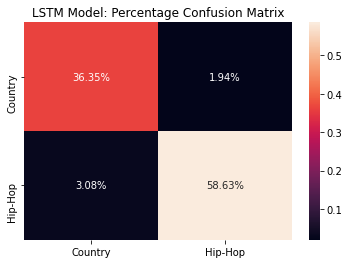

In [ ]:
#print(X_test_padded)
pred_class = np.argmax(pred, axis = 1)
y_labels = y_test.argmax(axis=1)

cf_matrix = confusion_matrix(y_labels, pred_class)
ax1 = plt.axes()
sns.heatmap(cf_matrix/np.sum(cf_matrix), ax = ax1, annot=True, 
            fmt='.2%', xticklabels = ["Country", "Hip-Hop" ],  yticklabels = ["Country", "Hip-Hop" ])
ax1.set_title("LSTM Model: Percentage Confusion Matrix")


In [ ]:
#take as input a sentence
#output = label, percentage score of hip hop vs country
txt = ["Snap back to reality, ope there goes gravity"]
txt =["But you're untouchable, burning brighter than the sun"]
txt = ["Romeo, take me somewhere we can be alone" , "But you're untouchable, burning brighter than the sun"]
txt = ["Flirtacious, tryin' to show patience"]
#tokenizer.texts_to_sequences(numpy_data)

prediction = model.predict(np.array(tokenizer.texts_to_sequences(txt)))
print(prediction)





[[0.5731103  0.42688975]]


In [ ]:
#use generated lyrics from text generation model
gen_lyrics = pd.read_csv("dataset/generated_lyrics.csv")
gen_lyrics.head()
lyr = gen_lyrics['Lyric Generated'].tolist()
display(gen_lyrics)
lyr = np.array(lyr)
text = tokenizer.texts_to_sequences(lyr)
#print(text)
t = np.array(text)
test = sequence.pad_sequences(t, maxlen=max_review_length)
#predict genre probability
p = model.predict(test)
#print(p)
pred_label = np.argmax(p, axis = 1)
c_values = p[:,0]
#print(c_values)
h_values = p[:,1]
#print(h_values)
#print(pred_class)
values = ["country", "rap"]
conditions = [
    (pred_label == 0),
    (pred_label== 1)]
gen_lyrics["Predicted_Genre"] = np.select(conditions, values)
gen_lyrics["Country Probability"] = c_values
gen_lyrics["Hip-Hop Probability"] = h_values

display(gen_lyrics)
gen_lyrics.to_csv('dataset/lyrics_genre.csv')

,Unnamed: 0,Lyric Generated,Genre
0,0,outro,rap
1,1,outro,rap
2,2,im gone of love with love,rap
3,3,outro,rap
4,4,outro megan malone,rap
...,...,...,...
125,60,yes in in my only cold your cant in in,country
126,61,yes please leave young who im be day what you ...,country
127,62,yes outro megan scott do,country
128,63,yes watchin wear about too stefani,country


,Unnamed: 0,Lyric Generated,Genre,Predicted_Genre,Country Probability,Hip-Hop Probability
0,0,outro,rap,country,0.587916,0.412084
1,1,outro,rap,country,0.587916,0.412084
2,2,im gone of love with love,rap,country,0.567778,0.432222
3,3,outro,rap,country,0.587916,0.412084
4,4,outro megan malone,rap,country,0.625910,0.374090
...,...,...,...,...,...,...
125,60,yes in in my only cold your cant in in,country,country,0.652883,0.347117
126,61,yes please leave young who im be day what you ...,country,country,0.600149,0.399851
127,62,yes outro megan scott do,country,country,0.533970,0.466030
128,63,yes watchin wear about too stefani,country,country,0.598678,0.401322


Text(0.5, 1.0, 'LSTM Model on Newly Generated Lyrics: Percentage Confusion Matrix')

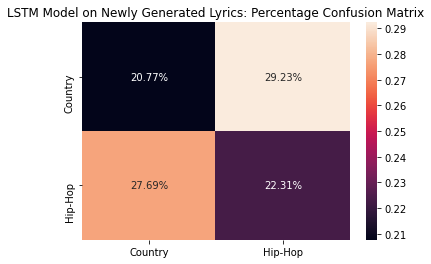

In [ ]:

cf_matrix = confusion_matrix(gen_lyrics["Genre"].values, gen_lyrics["Predicted_Genre"].values)
ax1 = plt.axes()
sns.heatmap(cf_matrix/np.sum(cf_matrix), ax = ax1, annot=True, 
            fmt='.2%', xticklabels = ["Country", "Hip-Hop" ],  yticklabels = ["Country", "Hip-Hop" ])
ax1.set_title("LSTM Model on Newly Generated Lyrics: Percentage Confusion Matrix")